## Overview
This notebook contains the complete pipeline for training a Pix2Pix model that converts a human-drawn sketch into a Chinese landscape painting. 

1. Obtain HED edge maps from the [Chinese landscape painting dataset](https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset) (Xue, 2020). 
2. Post-process the HED edge maps into sketch-like edge maps.
3. Train a Pix2Pix model on (sketch-like edge map, painting) pairs.
 

**Dependencies:**
Before you start, first upload
1. `hed.py`, and
2. `HED_pretrained_bsds.npz`
to `GDRIVE_PATH`

**Modifications to Google Drive:**
1. Creates a `sketch2paint_ckpts` directory to save intermediary model parameters

References
1. [Chinese landscape painting dataset](https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset) (Xue, 2020)
2. Holistically Nested Edge Detection(HED)
    - [paper](https://arxiv.org/abs/1504.06375) 
    - [pre-trained model](https://github.com/tensorpack/tensorpack/tree/master/examples/HED)  
3. Edge map post-processing - [SketchyGAN](https://arxiv.org/abs/1801.02753) (Section 3.3)
4. TensorFlow [pix2pix tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix)

## Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
GDRIVE_PATH = 'gdrive/MyDrive/ColabNotebooks/CSC2515_Project/Part2/sketch2paint/' # Replace with your own
PATH = '/root/.keras/'

In [ ]:
pip install -q tensorpack

     |████████████████████████████████| 296kB 5.9MB/s 


In [ ]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

import numpy as np
from scipy import ndimage
import cv2
import glob
from PIL import Image
from skimage import morphology
import math

In [ ]:
tf.random.set_seed(1234)

## Download Chinese Painting Dataset

In [ ]:
mkdir {PATH}paintings

In [ ]:
URLs = [
        'https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset/raw/main/All-Paintings/Harvard/Harvard-1.zip',
        'https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset/raw/main/All-Paintings/Metropolitan/Metropolitan-1.zip',
        'https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset/raw/main/All-Paintings/Metropolitan/Metropolitan-2.zip',
        'https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset/raw/main/All-Paintings/Princeton/Princeton-1.zip',
        'https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset/raw/main/All-Paintings/Princeton/Princeton-2.zip',
        'https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset/raw/main/All-Paintings/Smithsonian/Smithsonian-2.zip',
        'https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset/raw/main/All-Paintings/Smithsonian/Smithsonian-3.zip',
        'https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset/raw/main/All-Paintings/Smithsonian/Smithsonian-4.zip',
        'https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset/raw/main/All-Paintings/Smithsonian/Smithsonian-5.zip',
        'https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset/raw/main/All-Paintings/Smithsonian/Smithsonian-6.zip',
        'https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset/raw/main/All-Paintings/Smithsonian/Smithsonian-7.zip',
        'https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset/raw/main/All-Paintings/Smithsonian/Smithsonian-1.zip',
]

for i in range(len(URLs)):
  url = URLs[i]
  zip_name = url.split('/')[-1]
  tf.keras.utils.get_file(zip_name,
                          origin=url,
                          extract=False,
                          cache_subdir='paintings')

In [ ]:
!unzip -q -o -j '{PATH}paintings/*.zip' -d {PATH}paintings


12 archives were successfully processed.


## Generate HED Edge Maps

In [ ]:
mkdir hed

In [ ]:
!python {GDRIVE_PATH}hed.py --load {GDRIVE_PATH}HED_pretrained_bsds.npz --inpath "{PATH}paintings/*.jpg" --outpath hed

## Post-Process HED Edge Maps
This step aims to convert a painting's edge map into a form that resembles a human-drawn sketch. To achieve this, each HED edge map is binarized, thinned, and cleaned.

In [ ]:
'''
Returns a binarized image containing boolean values [True, False]
'''
def post_process_img(img):
  img = cv2.adaptiveThreshold(img, 255 ,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0)
  img = np.asarray(img, np.float32) / 255

  thinned = morphology.thin(img)
  cleaned = morphology.remove_small_objects(thinned, min_size=128, connectivity=2)
  return cleaned

In [ ]:
def post_process_all(in_path, out_path):
  files = glob.iglob(in_path, recursive=True)
  for f in files:
    img = cv2.imread(f, 0)
    img = post_process_img(img)

    image_name = f.split('/')[-1]
    image_name = image_name.split('.')[0]
    cv2.imwrite('{}/{}.jpg'.format(out_path, image_name), img * 255)

In [ ]:
mkdir hed_processed

In [ ]:
post_process_all('hed/*_3.jpg', 'hed_processed')

In [ ]:
%%script false
!zip -q -r hed.zip hed

In [ ]:
%%script false
!zip -q -r hed_processed.zip hed_processed

In [ ]:
%%script false
cp hed.zip {GDRIVE_PATH}hed.zip

In [ ]:
%%script false
cp hed_processed.zip {GDRIVE_PATH}hed_processed.zip

Try out different post-processing techniques.

(-0.5, 511.5, 511.5, -0.5)

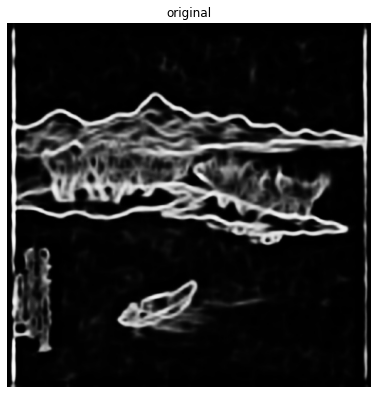

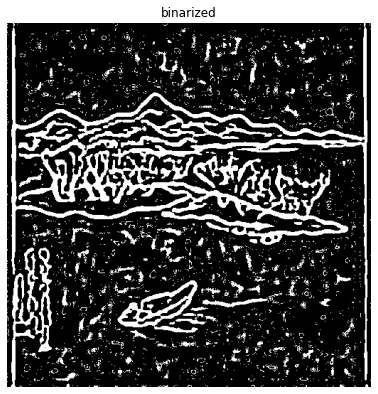

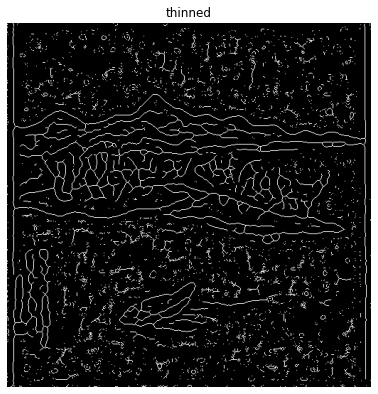

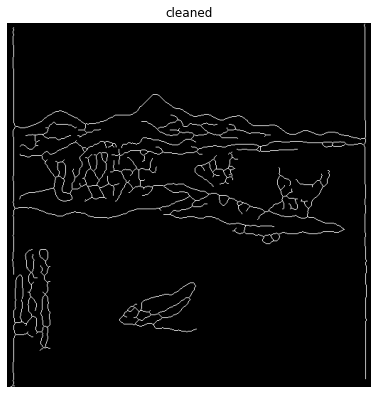

In [ ]:
%%script false
img = cv2.imread('hed/harvard_93_3.jpg', 0)
# _, binarized = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
# _, binarized = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
img = np.asarray(img)
# img[img < 100] = 0
binarized = cv2.adaptiveThreshold(img, 255 ,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0)

binarized = np.asarray(binarized, np.float32) / 255
thinned = morphology.thin(binarized)
# binarized = morphology.remove_small_objects(binarized, min_size=32, connectivity=2)
cleaned = morphology.remove_small_objects(thinned, min_size=128, connectivity=2)

plt.figure(figsize=(30,30))
plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.title('original')
plt.axis('off')

plt.figure(figsize=(30,30))
plt.subplot(1, 4, 2)
plt.imshow(binarized, cmap='gray')
plt.title('binarized')
plt.axis('off')

plt.figure(figsize=(30,30))
plt.subplot(1, 4, 3)
plt.imshow(thinned, cmap='gray')
plt.title('thinned')
plt.axis('off')

plt.figure(figsize=(30,30))
plt.subplot(1, 4, 4)
plt.imshow(cleaned, cmap='gray')
plt.title('cleaned')
plt.axis('off')

## Function Definitions

### Define the Generator


In [ ]:
OUTPUT_CHANNELS = 3
LAMBDA = 100

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Generator():
  inputs = tf.keras.layers.Input(shape=[512,512,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 256, 256, 64)
    downsample(128, 4), # (bs, 128, 128, 128)
    downsample(256, 4), # (bs, 64, 64, 256)
    downsample(512, 4), # (bs, 32, 32, 512)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(512, 4), # (bs, 32, 32, 1024)
    upsample(256, 4), # (bs, 64, 64, 512)
    upsample(128, 4), # (bs, 128, 128, 256)
    upsample(64, 4), # (bs, 256, 256, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 512, 512, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

### Define the Discriminator

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[512, 512, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[512, 512, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 512, 512, channels*2)

  down0 = downsample(64, 4, False)(x) # (bs, 256, 256, 64)
  down1 = downsample(128, 4)(down0) # (bs, 128, 128, 128)
  down2 = downsample(256, 4)(down1) # (bs, 64, 64, 256)
  down3 = downsample(512, 4)(down2) # (bs, 32, 32, 512)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 512)
  conv = tf.keras.layers.Conv2D(1024, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 1024)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 1024)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

### Helper Functions - Load Dataset

In [ ]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 512
IMG_HEIGHT = 512
EDGEMAP_DIR = 'hed/'
SKETCH_DIR = 'hed_processed/'
PAINTING_DIR = PATH + 'paintings/'

In [ ]:
def get_edgemap_name(input_file):
  edgemap_dir = tf.constant(EDGEMAP_DIR)

  filename = tf.strings.split(input_file, '/')[-1]
  filename_arr = tf.strings.split(filename, '_')
  filename = tf.strings.join([edgemap_dir, 
                              filename_arr[0], 
                              '_', 
                              filename_arr[1], 
                              '_2.jpg'])
  return filename

def grayscale_to_rgb(im):
  return tf.image.grayscale_to_rgb(im)

def get_painting_name(input_file):
  painting_dir = tf.constant(PAINTING_DIR)

  filename = tf.strings.split(input_file, '/')[-1]
  filename_arr = tf.strings.split(filename, '_')
  filename = tf.strings.join([painting_dir, 
                              filename_arr[0], 
                              '_', 
                              filename_arr[1], 
                              '.jpg'])
  return filename

def identity(im):
  return im

In [ ]:
'''
Loads (input, target) pairs 
'''
def load(input_file, get_target_name, post_process_input, post_process_target):
  input = tf.io.read_file(input_file)
  input = tf.image.decode_jpeg(input)
  input = tf.cast(input, tf.float32)
  input = post_process_input(input)

  target_path = get_target_name(input_file)
  target = tf.io.read_file(target_path)
  target = tf.image.decode_jpeg(target)
  target = tf.cast(target, tf.float32)
  target = post_process_target(target)
  return input, target

In [ ]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

# normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, IMG_HEIGHT + 60, IMG_WIDTH + 60)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)
  
  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

def sketch2paint_load_image_train(image_file):
  input_image, real_image = load(image_file, get_painting_name, grayscale_to_rgb, identity)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image

def sketch2paint_load_image_test(image_file):
  input_image, real_image = load(image_file, get_painting_name, grayscale_to_rgb, identity)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image

### Helper Functions - Display Images

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

### Helper Functions - Training

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))


def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 10 epochs
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

## sketch2paint Model Training

### Load Dataset to Local Runtime


In [ ]:
%%script false
# Load previously generated sketch-like edge maps
!unzip -q {GDRIVE_PATH}hed_processed.zip -d hed_processed

In [ ]:
def get_im_from_path(im_path):
  im = Image.open(im_path)
  im_array = np.asarray(im, dtype=np.float32)
  return im_array

def get_sketch_name_from_painting(input_file):
  sketch_dir = tf.constant(SKETCH_DIR)

  filename = tf.strings.split(input_file, '/')[-1]
  filename = tf.strings.split(filename, '.')[0]
  filename = tf.strings.join([sketch_dir, 
                              filename, 
                              '_3.jpg'])
  return filename.numpy()


def remove_orig_imgs():
  # get all images
  files = glob.iglob(PATH + 'paintings/*.jpg', recursive=True)
  for f in files:
    # remove grayscale imgs
    im = get_im_from_path(f)
    if(im.shape != (IMG_HEIGHT, IMG_WIDTH, 3)):
      sketch_path = get_sketch_name_from_painting(f)
      
      os.remove(f)
      os.remove(sketch_path)


In [ ]:
remove_orig_imgs()

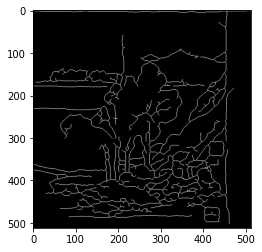

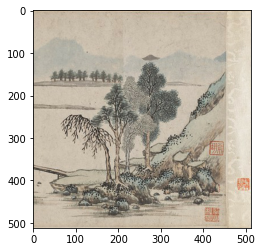

In [ ]:
inp, re = load('hed_processed/harvard_0_3.jpg', get_painting_name, grayscale_to_rgb, identity)
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [ ]:
all_dataset = tf.data.Dataset.list_files('hed_processed/*_3.jpg'.format(PATH))
test_dataset = all_dataset.take(50) 
train_dataset = all_dataset.skip(50)

train_dataset = train_dataset.map(sketch2paint_load_image_train)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = test_dataset.map(sketch2paint_load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Define the Optimizers and Checkpoint-Saver


In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = GDRIVE_PATH + 'sketch2paint_ckpts'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Restore the Latest Checkpoint
Restore the previously-saved checkpoint if there is any. 


In [ ]:
!ls {checkpoint_dir}

checkpoint		     ckpt-12.index		  ckpt-23.index
ckpt-12.data-00000-of-00001  ckpt-23.data-00000-of-00001


In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Display Generated Images

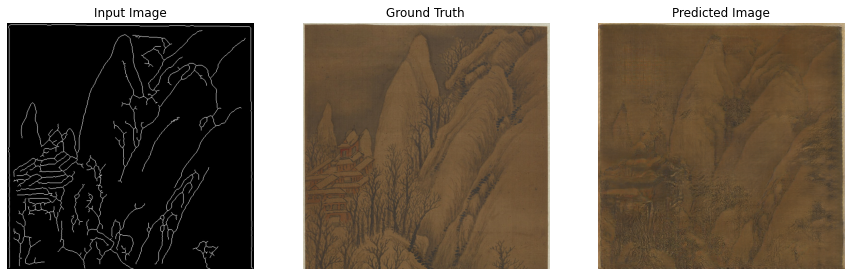

In [ ]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

### Training

In [ ]:
EPOCHS = 200

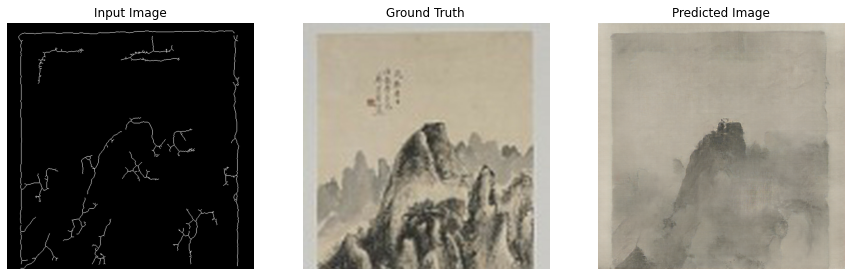

Epoch:  62
.........................Buffered data was truncated after reaching the output size limit.

In [ ]:
fit(train_dataset, EPOCHS, test_dataset)

### Generate using Test Dataset

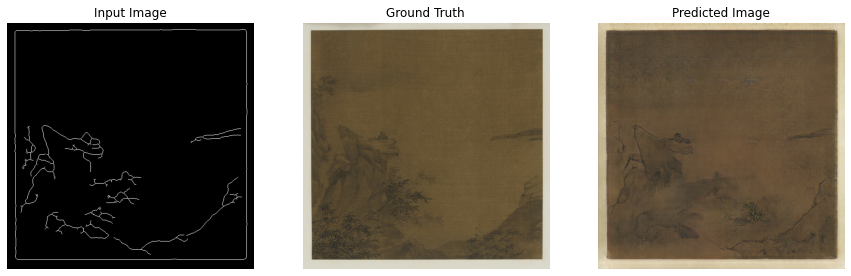

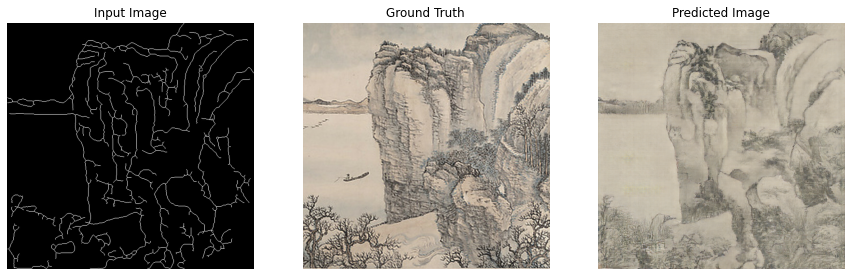

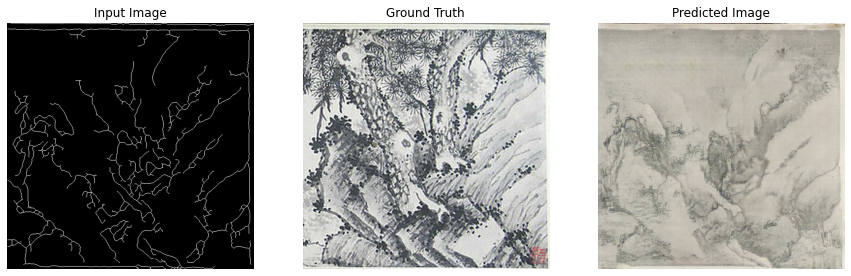

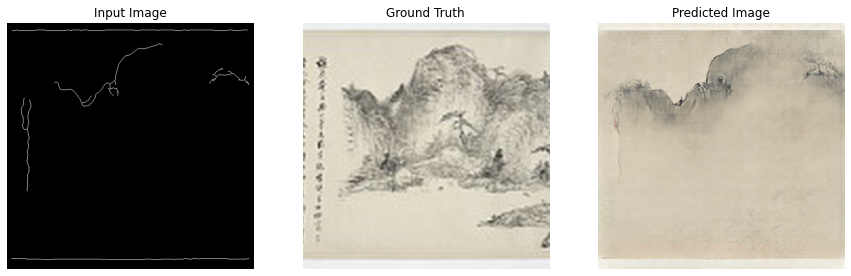

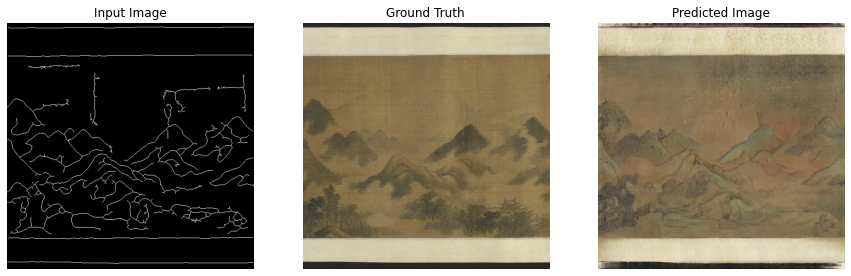

In [ ]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

### Save and Re-Load Model

In [ ]:
model_name = 'pix2pix_model512_400_sketch2paint'


In [ ]:
saved_model_path = GDRIVE_PATH + model_name

generator.save(saved_model_path, include_optimizer=False)

In [ ]:
cd {GDRIVE_PATH}

In [ ]:
!zip -r {model_name}.zip {model_name}

In [ ]:
cd /content

In [ ]:
!unzip {GDRIVE_PATH}{model_name}.zip -d {model_name}

In [ ]:
sketch2paint_generator = tf.saved_model.load(model_name + '/' + model_name)

### Generate Paintings from Human Sketches

In [29]:
mkdir human_sketches

Upload some 512x512 sketches to the above directory. An example sketch is shown below.

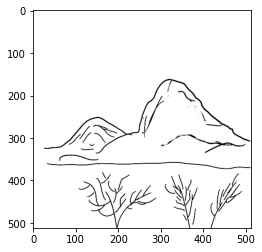

In [47]:
img = cv2.imread('human_sketches/Sketch10.png', 0)
img = np.asarray(img) / 255
plt.imshow(img, cmap='gray')
plt.show()

In [30]:
mkdir human_sketches_processed

In [ ]:
# Same as post_process_img, except for the cleaning step
def post_process_human_sketch(img):
  img = cv2.adaptiveThreshold(img, 255 ,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0)
  img = np.asarray(img, np.float32) / 255

  thinned = morphology.thin(img)
  return thinned

def post_process_human_sketches(in_path, out_path):
  files = glob.iglob(in_path, recursive=True)
  for f in files:
    img = cv2.imread(f, 0)
    img = 255 - img
    img = post_process_human_sketch(img)

    image_name = f.split('/')[-1]
    image_name = image_name.split('.')[0]
    cv2.imwrite('{}/{}.jpg'.format(out_path, image_name), img * 255)

In [ ]:
def generate_painting(model, test_input):
  prediction = model(test_input, training=True)
  fig = plt.figure(figsize=(15,15))
  
  display_list = [test_input[0], prediction[0]]
  title = ['Sketch', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

def edgemap_to_painting_predict(path):
  sketches = glob.iglob(path + '*.jpg', recursive=True)
  for sketch in sketches:
    im = Image.open(sketch)
    im = im.convert('RGB')
    im = np.asarray(im, dtype=np.float32)
    im = tf.constant(im)

    input_image, _ = normalize(im, im)
    input_image = tf.expand_dims(input_image, 0)
    print(sketch)
    generate_painting(sketch2paint_generator, input_image)

human_sketches_processed/Sketch12.jpg


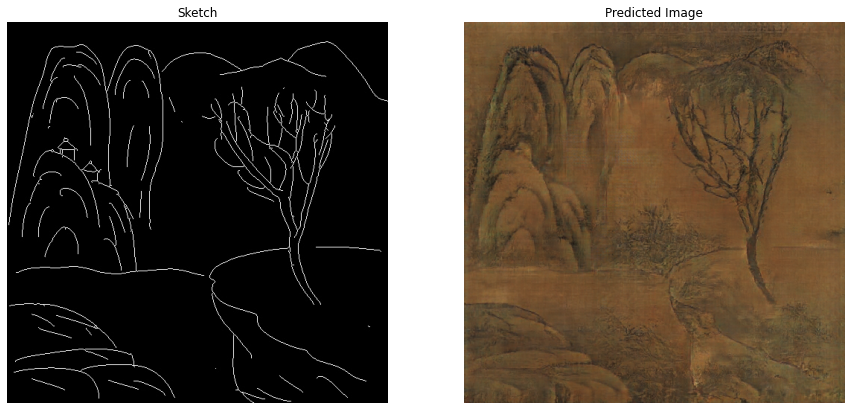

human_sketches_processed/Sketch9.jpg


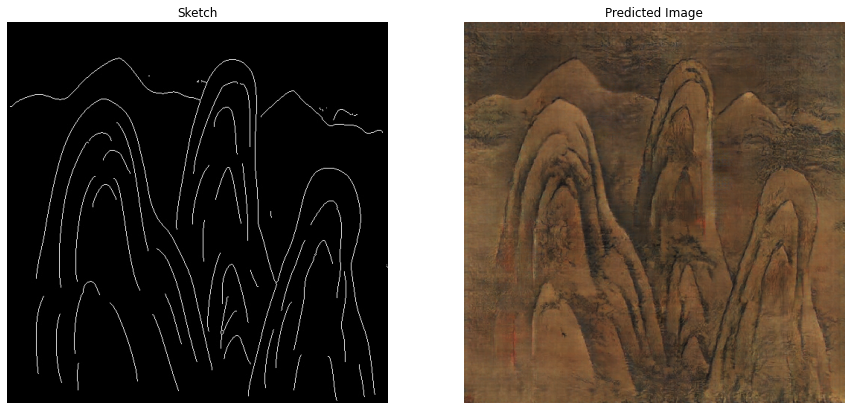

human_sketches_processed/Sketch14.jpg


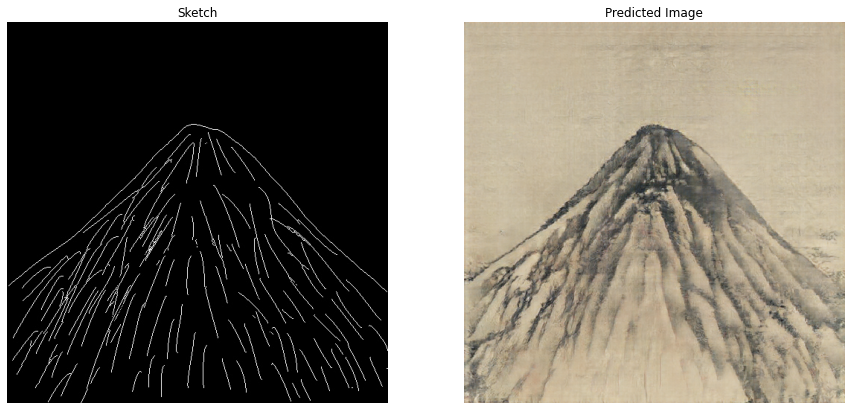

human_sketches_processed/Sketch10.jpg


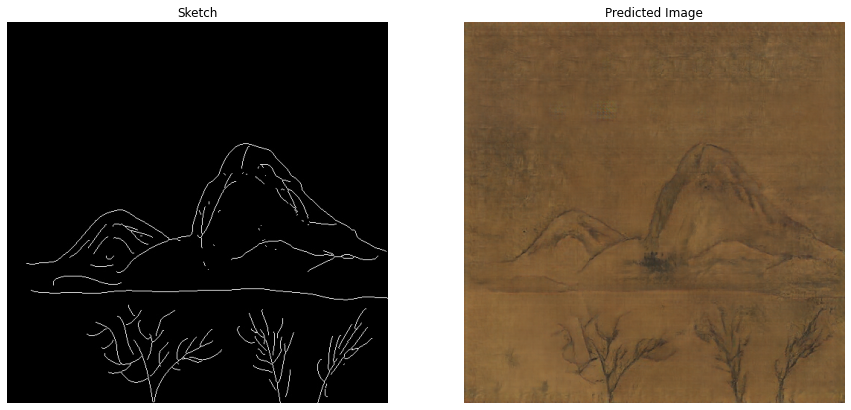

human_sketches_processed/Sketch2.jpg


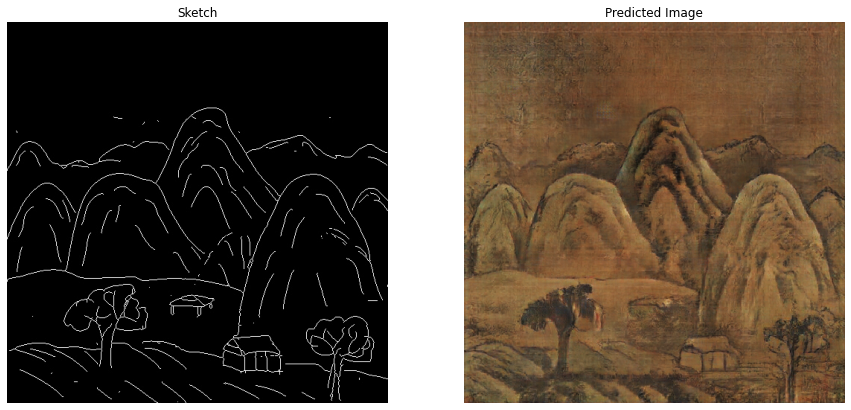

human_sketches_processed/Sketch16.jpg


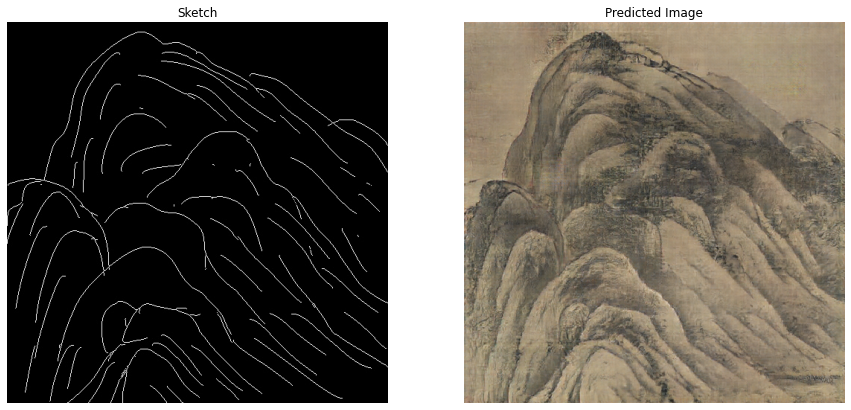

human_sketches_processed/Sketch8.jpg


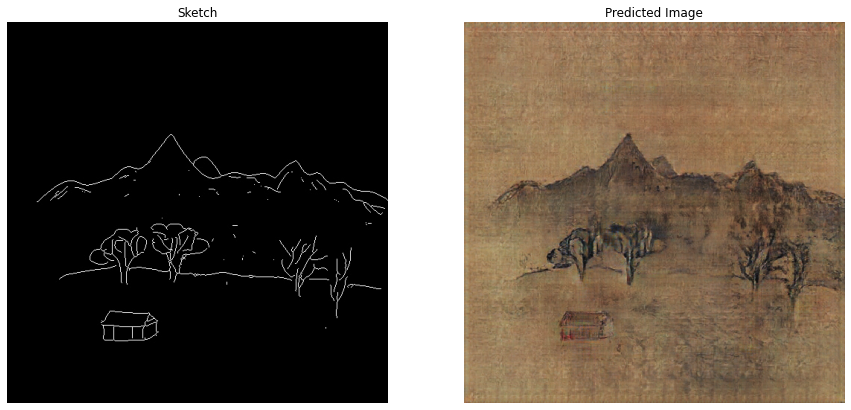

human_sketches_processed/Sketch4.jpg


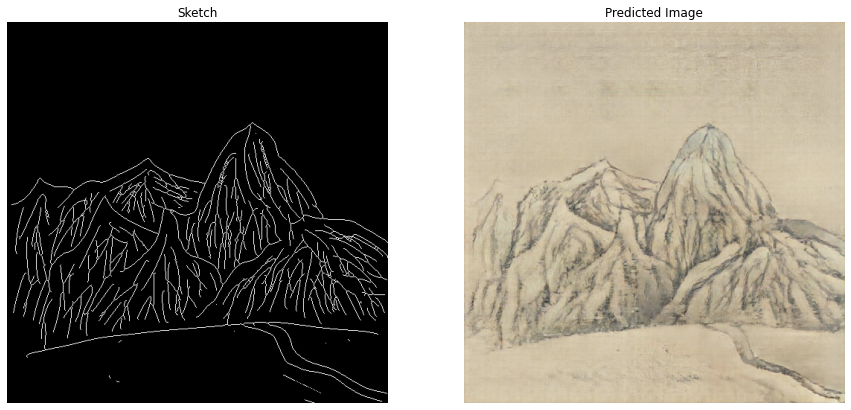

human_sketches_processed/Sketch13.jpg


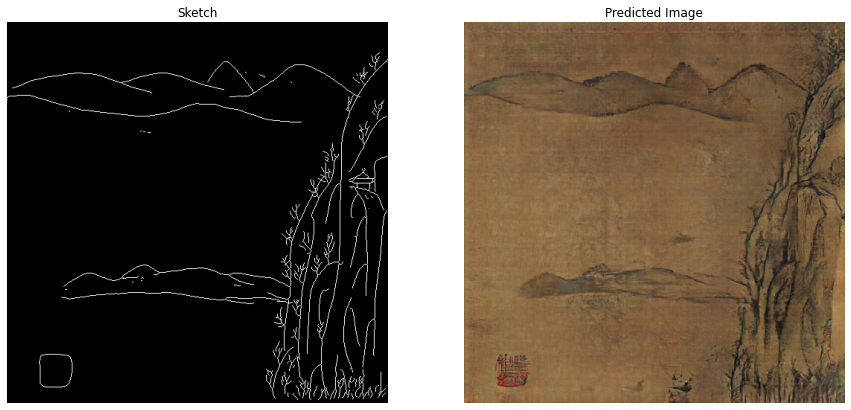

In [44]:
post_process_human_sketches('human_sketches/*.png', 'human_sketches_processed')
edgemap_to_painting_predict('human_sketches_processed/')

## Summary
### Features
- The model is best at colorizing mountains and rocks.
- It is also able to synthesize trees, houses, and stamps. 

### Limitations
- The model is not good at synthesizing sohpisticated terrains from simple sketches. Smooth lines produce smooth mountains.
- The model sometimes mistake trees for rocks and houses for red stamps.  